### Altre condizioni
* spazio stanza per bambino

In [1]:
import pandas as pd
import numpy as np

n = 5000
df = pd.DataFrame()

# ----------------------
# Parent's age
# ----------------------
age1 = np.clip(np.random.normal(42, 8, n), 30, 62)
age_diff = np.clip(np.random.normal(0, 3, n), -15, 15)
raw_age2 = age1 + age_diff
age2 = np.clip(raw_age2, 30, 62)

df['age_parent_1'] = age1.astype(int)
df['age_parent_2'] = age2.astype(int)

df['mean_age_parents'] = (df['age_parent_1'] + df['age_parent_2']) / 2

# ----------------------
# Civil status
# ----------------------
df['civil_status'] = np.random.choice(['married', 'cohabitants'], n, p=[0.9, 0.1])

# ----------------------
# Years of relation
# ----------------------
def generate_years_of_relation(age1, age2):
    min_age = min(age1, age2)
    max_years = min_age - 18
    if max_years <= 1:
        return 1
    mode = int(max(max_years * 0.75, 1))
    mode = min(mode, max_years)
    return int(np.random.triangular(1, mode, max_years))

df['years_of_relation'] = df.apply(lambda row: generate_years_of_relation(row['age_parent_1'], row['age_parent_2']), axis=1)


# ----------------------
# Educational capacity
# ----------------------
df['ability_to_educate'] = np.random.choice(['yes', 'no'], size=n, p=[0.75, 0.25])

# ----------------------
# Criminal records for at least one parent
# ----------------------
df['criminal_record'] = np.random.choice(['yes', 'no'], size=n, p=[0.06, 0.94])


# ----------------------
# Biological children
# ----------------------
df['biological_children'] = np.random.choice([0, 1, 2], size=n, p=[0.84, 0.14, 0.02])


# ----------------------
# Educational level
# ----------------------
df['education_parent_1'] = np.random.choice(['medium_school', 'high_school', 'degree'], size=n, p=[0.01, 0.42, 0.57])
df['education_parent_2'] = np.random.choice(['medium_school', 'high_school', 'degree'], size=n, p=[0.05, 0.23, 0.72])


# ----------------------
# Weekly hours of work
# ----------------------

df['weekly_work_hours_parent_1'] = np.random.choice([0, 20, 25, 30, 35, 40, 45, 50], size=n, p=[0.26, 0.07, 0.04, 0.04, 0.11, 0.37, 0.07, 0.04])
df['weekly_work_hours_parent_2'] = np.random.choice([0, 20, 25, 30, 35, 40, 45, 50], size=n, p=[0.38, 0.19, 0.03, 0.03, 0.06, 0.25, 0.04, 0.02])

# ----------------------
# Years of work with weekly hours condition
# ----------------------
def calculate_years_of_work(age, education, weekly_hours):
    if weekly_hours == 0:
        return 0
    if education == 'medium_school':
        start_work_age = 16
    elif education == 'high_school':
        start_work_age = 20
    else:  # 'degree'
        start_work_age = 25
    years_of_work = max(age - start_work_age, 0)
    return years_of_work

df['years_of_work_parent_1'] = df.apply(lambda row: calculate_years_of_work(row['age_parent_1'], row['education_parent_1'], row['weekly_work_hours_parent_1']), axis=1)
df['years_of_work_parent_2'] = df.apply(lambda row: calculate_years_of_work(row['age_parent_2'], row['education_parent_2'], row['weekly_work_hours_parent_2']), axis=1)

# ----------------------
# Type of contract
# ----------------------
def assign_contract_type(weekly_hours):
    if weekly_hours == 0:
        return 'no_contract'
    return np.random.choice(['permanent', 'temporary', 'self_employed'], p=[0.66, 0.12, 0.22])

df['type_of_contract_parent_1'] = df['weekly_work_hours_parent_1'].apply(assign_contract_type)
df['type_of_contract_parent_2'] = df['weekly_work_hours_parent_2'].apply(assign_contract_type)

# ----------------------
# Preferences on age or race of children
# ----------------------
df['preferences'] = np.random.choice([0, 1], size=n, p=[0.2, 0.8])

# ----------------------
# House contract
# ----------------------
df['house_contract'] = np.random.choice(['property', 'rent', 'usufruct'], size=n, p=[0.71, 0.20, 0.09])

# ----------------------
# House square meters
# ----------------------
df['house_square_meters'] = np.clip(np.random.normal(118, 50, size=n), 35, None).round(1)

# ----------------------
# House rooms
# ----------------------
def estimate_rooms(sqm):
    if sqm <= 70:
        return np.random.choice([2, 3, 4])
    elif sqm <= 100:
        return np.random.choice([3, 4, 5, 6])
    elif sqm <= 130:
        return np.random.choice([5, 6, 7, 8])
    else:
        return np.random.choice([6, 7, 8, 9, 10, 11, 12])

df['number_of_rooms'] = df['house_square_meters'].apply(estimate_rooms)

# ----------------------
# Space for children room
# ----------------------

def determine_space(row):
    total_rooms = row['number_of_rooms']
    total_sqm = row['house_square_meters']
    biological_children = row['biological_children']

    fixed_rooms = 1 + 1 + 1
    fixed_bathrooms = 2 if biological_children >= 1 else 1
    total_fixed = fixed_rooms + fixed_bathrooms

    children_rooms = biological_children

    occupied_rooms = total_fixed + children_rooms

    remaining_rooms = total_rooms - occupied_rooms

    if remaining_rooms >= 1:
        return 'room_present'
    else:
        # Se ipotizziamo di aggiungere una stanza in più
        rooms_with_new = total_rooms + 1
        sqm_per_room = total_sqm / rooms_with_new
        if sqm_per_room > 21:
            return 'space_present'
        else:
            return 'no_space'

df['space_for_new_child'] = df.apply(determine_space, axis=1)

# ----------------------
# Salary
# ----------------------
def get_contract_hourly_wage(contract_type, parent_number):
    if contract_type == '  ':
        return 10.75 if parent_number == 1 else 10.41
    elif contract_type == 'tempo_indeterminato':
        return 13.16 if parent_number == 1 else 11.97
    else:
        return 13.74 if parent_number ==1 else 12.12

def get_education_factor(education, parent_number):
    if education in ['none', 'medium_school']:
        return 11.7 if parent_number == 1 else 10.5
    elif education == 'high_school':
        return 12.6 if parent_number == 1 else 11.4
    elif education == 'degree':
        return 17.3 if parent_number == 1 else 13.5

def get_age_factor(age, parent_number):
    if age < 30:
        return 12.47 if parent_number == 1 else 11.42
    elif age < 50:
        return 17.41 if parent_number == 1 else 13.12
    else:
        return 22.11 if parent_number == 1 else 14.57

def compute_hourly_wage(contract_type, education, age, parent_number):
    if pd.isna(contract_type) or contract_type == 'NA':
        return 0

    contract_wage = get_contract_hourly_wage(contract_type, parent_number)
    education_factor = get_education_factor(education, parent_number)
    age_factor = get_age_factor(age, parent_number)

    weighted_wage = (contract_wage * 0.4) + (education_factor * 0.3) + (age_factor * 0.3)

    noise = np.random.normal(1.0, 0.1)
    return round(weighted_wage * noise, 2)

def compute_annual_salary(row, parent_number):
    contract_col = f'type_of_contract_parent_{parent_number}'
    education_col = f'education_parent_{parent_number}'
    age_col = f'age_parent_{parent_number}'
    weekly_hours_col = f'weekly_work_hours_parent_{parent_number}'

    hourly_wage = compute_hourly_wage(row[contract_col], row[education_col], row[age_col], parent_number)
    weekly_hours = row[weekly_hours_col]

    return round(hourly_wage * weekly_hours * 48)

df['salary_parent_1'] = df.apply(lambda row: compute_annual_salary(row, 1), axis=1)
df['salary_parent_2'] = df.apply(lambda row: compute_annual_salary(row, 2), axis=1)

df['total_couple_salary'] = df['salary_parent_1'] + df['salary_parent_2']


In [2]:
df.head()

,age_parent_1,age_parent_2,mean_age_parents,civil_status,years_of_relation,ability_to_educate,criminal_record,biological_children,education_parent_1,education_parent_2,...,type_of_contract_parent_1,type_of_contract_parent_2,preferences,house_contract,house_square_meters,number_of_rooms,space_for_new_child,salary_parent_1,salary_parent_2,total_couple_salary
0,49,43,46.0,married,14,yes,no,0,high_school,degree,...,permanent,no_contract,1,property,155.6,10,room_present,14170,0,14170
1,44,47,45.5,married,14,yes,no,0,degree,degree,...,self_employed,permanent,1,property,145.2,12,room_present,33372,12998,46370
2,46,48,47.0,married,4,yes,no,0,high_school,medium_school,...,permanent,no_contract,0,usufruct,35.0,4,no_space,26074,0,26074
3,44,48,46.0,married,19,yes,no,0,degree,degree,...,permanent,permanent,1,property,137.0,10,room_present,18792,12019,30811
4,41,41,41.0,married,11,no,no,0,high_school,high_school,...,temporary,permanent,0,property,115.6,8,room_present,29126,11117,40243


In [3]:
df.columns

Index(['age_parent_1', 'age_parent_2', 'mean_age_parents', 'civil_status',
       'years_of_relation', 'ability_to_educate', 'criminal_record',
       'biological_children', 'education_parent_1', 'education_parent_2',
       'weekly_work_hours_parent_1', 'weekly_work_hours_parent_2',
       'years_of_work_parent_1', 'years_of_work_parent_2',
       'type_of_contract_parent_1', 'type_of_contract_parent_2', 'preferences',
       'house_contract', 'house_square_meters', 'number_of_rooms',
       'space_for_new_child', 'salary_parent_1', 'salary_parent_2',
       'total_couple_salary'],
      dtype='object')

In [4]:
def decide_with_score(row):
    score = 0
    # hard screening
    if row['years_of_relation'] < 3:
        return pd.Series([0, score])
    if row['ability_to_educate'] == 0:
        return pd.Series([0, score])
    if row['criminal_record'] == 'yes':
        return pd.Series([0, score])
    if row['space_for_new_child'] == 'no_space':
        return pd.Series([0, score])

    # score computing
    if 35 <= row['mean_age_parents'] <= 40:
        score += 2
    elif 30 <= row['mean_age_parents'] < 35 or 40 < row['mean_age_parents'] <= 45:
        score += 1
    elif 45 < row['mean_age_parents'] <= 50:
        score += 0
    else:
        score -= 1

    if row['age_parent_1'] < 30 or row['age_parent_1'] > 55:
        score -= 1
    if row['age_parent_2'] < 30 or row['age_parent_2'] > 55:
        score -= 1

    if row['civil_status'] == 'married':
        score += 1

    extra_years = row['years_of_relation'] - 3
    score += extra_years * 0.2

    if row['biological_children'] == 0:
        score += 0.5
    elif row['biological_children'] == 1:
        score += 0  # neutro
    elif row['biological_children'] >= 2:
        score -= 0.5

    edu1 = row['education_parent_1']
    edu2 = row['education_parent_2']
    if edu1 == 'degree' and edu2 == 'degree':
        score += 2
    elif (edu1 == 'degree' and edu2 == 'high_school') or (edu2 == 'degree' and edu1 == 'high_school'):
        score += 1
    elif (edu1 == 'high_school' and edu2 == 'high_school') or (edu1 == 'degree' and edu2 == 'medium_school') or (edu2 == 'degree' and edu1 == 'medium_school'):
        score += 0
    elif edu1 == 'middle_school' and edu2 == 'middle_school':
        score -= 2
    else:
        score -= 1

    total_hours = row['weekly_work_hours_parent_1'] + row['weekly_work_hours_parent_2']
    work_diff = 74 - total_hours
    score += work_diff * 0.1

    total_years_work = row['years_of_work_parent_1'] + row['years_of_work_parent_2']
    work_years_diff = total_years_work - 6
    score += work_years_diff * 0.05

    contracts = [row['type_of_contract_parent_1'], row['type_of_contract_parent_2']]
    for contract in contracts:
        if contract in ['permanent', 'self_employed']:
            score += 1
        elif contract == 'temporary':
            score -= 0.5

    if row['preferences'] == 1:
        score -= 0.5

    if row['house_contract'] == 'property':
        score += 1
    elif row['house_contract'] == 'rent':
        score -= 0.3
    elif row['house_contract'] == 'usufruct':
        score -= 1

    sqm_diff = row['house_square_meters'] - 118
    score += sqm_diff * 0.01

    room_diff = row['number_of_rooms'] - 5
    score += room_diff * 0.3

    if row['space_for_new_child'] == 'room_present':
        score += 1

    salary_diff = row['total_couple_salary'] - 60568
    score += salary_diff / 10000

    decision = 1 if score >= 10 else 0
    return pd.Series([decision, score])

df[['approved', 'score']] = df.apply(decide_with_score, axis=1)


In [5]:
df

,age_parent_1,age_parent_2,mean_age_parents,civil_status,years_of_relation,ability_to_educate,criminal_record,biological_children,education_parent_1,education_parent_2,...,preferences,house_contract,house_square_meters,number_of_rooms,space_for_new_child,salary_parent_1,salary_parent_2,total_couple_salary,approved,score
0,49,43,46.0,married,14,yes,no,0,high_school,degree,...,1,property,155.6,10,room_present,14170,0,14170,1.0,10.9862
1,44,47,45.5,married,14,yes,no,0,degree,degree,...,1,property,145.2,12,room_present,33372,12998,46370,1.0,12.8022
2,46,48,47.0,married,4,yes,no,0,high_school,medium_school,...,0,usufruct,35.0,4,no_space,26074,0,26074,0.0,0.0000
3,44,48,46.0,married,19,yes,no,0,degree,degree,...,1,property,137.0,10,room_present,18792,12019,30811,1.0,13.6143
4,41,41,41.0,married,11,no,no,0,high_school,high_school,...,0,property,115.6,8,room_present,29126,11117,40243,0.0,8.6435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,30,30,30.0,married,6,yes,no,1,high_school,degree,...,1,property,43.0,2,no_space,22898,24749,47647,0.0,0.0000
4996,32,32,32.0,cohabitants,5,yes,no,0,high_school,high_school,...,1,property,143.3,12,room_present,30317,11712,42029,0.0,8.1991
4997,30,30,30.0,married,5,yes,no,0,degree,degree,...,0,property,95.3,4,no_space,0,10627,10627,0.0,0.0000
4998,52,52,52.0,married,29,yes,no,1,high_school,medium_school,...,0,property,66.3,3,no_space,0,24710,24710,0.0,0.0000


In [6]:
df['approved'].value_counts(normalize=True).rename_axis('approved').reset_index(name='percentage (%)')


,approved,percentage (%)
0,0.0,0.7354
1,1.0,0.2646


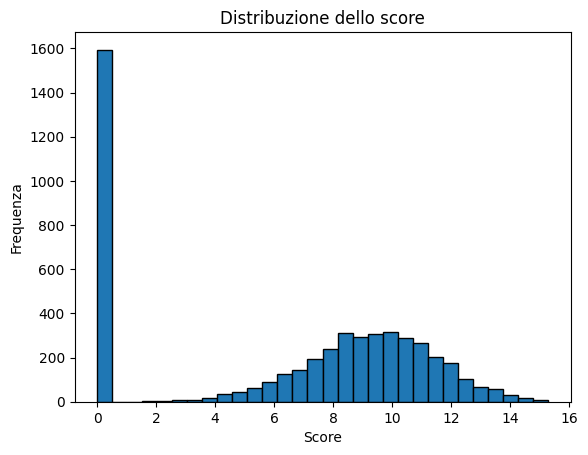

In [7]:
import matplotlib.pyplot as plt

plt.hist(df['score'], bins=30, edgecolor='k')
plt.title('Distribuzione dello score')
plt.xlabel('Score')
plt.ylabel('Frequenza')
plt.show()


## Modelli

In [8]:
print(df.civil_status.value_counts(), "\n")
print(df.ability_to_educate.value_counts(), "\n")
print(df.criminal_record.value_counts(), "\n")
print(df.education_parent_1.value_counts(), "\n")
print(df.education_parent_2.value_counts(), "\n")
print(df.type_of_contract_parent_1.value_counts(), "\n")
print(df.type_of_contract_parent_2.value_counts(), "\n")
print(df.house_contract.value_counts(), "\n")
print(df.space_for_new_child.value_counts())

civil_status
married        4495
cohabitants     505
Name: count, dtype: int64 

ability_to_educate
yes    3749
no     1251
Name: count, dtype: int64 

criminal_record
no     4706
yes     294
Name: count, dtype: int64 

education_parent_1
degree           2883
high_school      2063
medium_school      54
Name: count, dtype: int64 

education_parent_2
degree           3611
high_school      1137
medium_school     252
Name: count, dtype: int64 

type_of_contract_parent_1
permanent        2441
no_contract      1313
self_employed     811
temporary         435
Name: count, dtype: int64 

type_of_contract_parent_2
permanent        2104
no_contract      1909
self_employed     668
temporary         319
Name: count, dtype: int64 

house_contract
property    3521
rent        1017
usufruct     462
Name: count, dtype: int64 

space_for_new_child
room_present     3458
no_space         1316
space_present     226
Name: count, dtype: int64


In [9]:
df['civil_status_num'] = df['civil_status'].map({'cohabitants': 0, 'married': 1})
df = df.drop('civil_status', axis = 1)

df['ability_to_educate_num'] = df['ability_to_educate'].map({'no': 0, 'yes': 1})
df = df.drop('ability_to_educate', axis = 1)

df['criminal_record_num'] = df['criminal_record'].map({'no': 0, 'yes': 1})
df = df.drop('criminal_record', axis = 1)

df

,age_parent_1,age_parent_2,mean_age_parents,years_of_relation,biological_children,education_parent_1,education_parent_2,weekly_work_hours_parent_1,weekly_work_hours_parent_2,years_of_work_parent_1,...,number_of_rooms,space_for_new_child,salary_parent_1,salary_parent_2,total_couple_salary,approved,score,civil_status_num,ability_to_educate_num,criminal_record_num
0,49,43,46.0,14,0,high_school,degree,20,0,29,...,10,room_present,14170,0,14170,1.0,10.9862,1,1,0
1,44,47,45.5,14,0,degree,degree,45,20,19,...,12,room_present,33372,12998,46370,1.0,12.8022,1,1,0
2,46,48,47.0,4,0,high_school,medium_school,40,0,26,...,4,no_space,26074,0,26074,0.0,0.0000,1,1,0
3,44,48,46.0,19,0,degree,degree,25,20,19,...,10,room_present,18792,12019,30811,1.0,13.6143,1,1,0
4,41,41,41.0,11,0,high_school,high_school,40,20,21,...,8,room_present,29126,11117,40243,0.0,8.6435,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,30,30,30.0,6,1,high_school,degree,35,40,10,...,2,no_space,22898,24749,47647,0.0,0.0000,1,1,0
4996,32,32,32.0,5,0,high_school,high_school,40,20,12,...,12,room_present,30317,11712,42029,0.0,8.1991,0,1,0
4997,30,30,30.0,5,0,degree,degree,0,20,0,...,4,no_space,0,10627,10627,0.0,0.0000,1,1,0
4998,52,52,52.0,29,1,high_school,medium_school,0,40,0,...,3,no_space,0,24710,24710,0.0,0.0000,1,1,0


In [10]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(categories=[['medium_school', 'high_school', 'degree']])
df['education_parent_1_ord'] = enc.fit_transform(df[['education_parent_1']])
df = df.drop('education_parent_1', axis=1)

df['education_parent_2_ord'] = enc.fit_transform(df[['education_parent_2']])
df = df.drop('education_parent_2', axis=1)

enc = OrdinalEncoder(categories=[['no_space', 'space_present', 'room_present']])
df['space_for_new_child_ord'] = enc.fit_transform(df[['space_for_new_child']])
df = df.drop('space_for_new_child', axis=1)

In [13]:
dummies = pd.get_dummies(df['type_of_contract_parent_1'], prefix='contract_parent_1', dtype=int)
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['type_of_contract_parent_2'], prefix='contract_parent_2', dtype=int)
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['house_contract'], prefix='house_contract', dtype=int)
df = pd.concat([df, dummies], axis=1)

df = df.drop('type_of_contract_parent_1', axis=1)
df = df.drop('type_of_contract_parent_2', axis=1)
df = df.drop('house_contract', axis=1)
df

,age_parent_1,age_parent_2,mean_age_parents,years_of_relation,biological_children,weekly_work_hours_parent_1,weekly_work_hours_parent_2,years_of_work_parent_1,years_of_work_parent_2,preferences,...,contract_parent_1_permanent,contract_parent_1_self_employed,contract_parent_1_temporary,contract_parent_2_no_contract,contract_parent_2_permanent,contract_parent_2_self_employed,contract_parent_2_temporary,house_contract_property,house_contract_rent,house_contract_usufruct
0,49,43,46.0,14,0,20,0,29,0,1,...,1,0,0,1,0,0,0,1,0,0
1,44,47,45.5,14,0,45,20,19,22,1,...,0,1,0,0,1,0,0,1,0,0
2,46,48,47.0,4,0,40,0,26,0,0,...,1,0,0,1,0,0,0,0,0,1
3,44,48,46.0,19,0,25,20,19,23,1,...,1,0,0,0,1,0,0,1,0,0
4,41,41,41.0,11,0,40,20,21,21,0,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,30,30,30.0,6,1,35,40,10,5,1,...,1,0,0,0,0,0,1,1,0,0
4996,32,32,32.0,5,0,40,20,12,12,1,...,1,0,0,0,1,0,0,1,0,0
4997,30,30,30.0,5,0,0,20,0,5,0,...,0,0,0,0,1,0,0,1,0,0
4998,52,52,52.0,29,1,0,40,0,36,0,...,0,0,0,0,0,1,0,1,0,0


In [15]:
# 1. Import delle librerie
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y = df['approved']
X = df.drop('approved', axis=1)
# 3. Suddivisione in train e test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Costruzione di una pipeline con scaling e classificatore
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42,
        class_weight="balanced"  # utile se le classi sono sbilanciate
    ))
])

# 5. Addestramento del modello
pipeline.fit(X_train, y_train)

# 6. Valutazione sul test set
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       735
         1.0       1.00      1.00      1.00       265

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Confusion Matrix:
 [[735   0]
 [  0 265]]
